In [2]:
import gdax
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

from datetime import datetime, timedelta
from math import ceil
from time import sleep

from backtest import Trader, DoubleTrader, historic_rates
from algorithms import SMA, EMA, MovingAverageAlgo

%matplotlib inline
public_client = gdax.PublicClient()

From: 2018-02-18T16:32:41, To: 2018-02-19T21:42:41
From: 2018-02-17T11:22:41, To: 2018-02-18T16:32:41
From: 2018-02-16T06:12:41, To: 2018-02-17T11:22:41
From: 2018-02-15T01:02:41, To: 2018-02-16T06:12:41
From: 2018-02-13T19:52:41, To: 2018-02-15T01:02:41
From: 2018-02-12T14:42:41, To: 2018-02-13T19:52:41
2106
128.36829860105644
[7010.29, 7008.63, 6995.12, 7005, 7040, 7026.63, 7039.99, 7039.03, 7030.81, 7044.99]


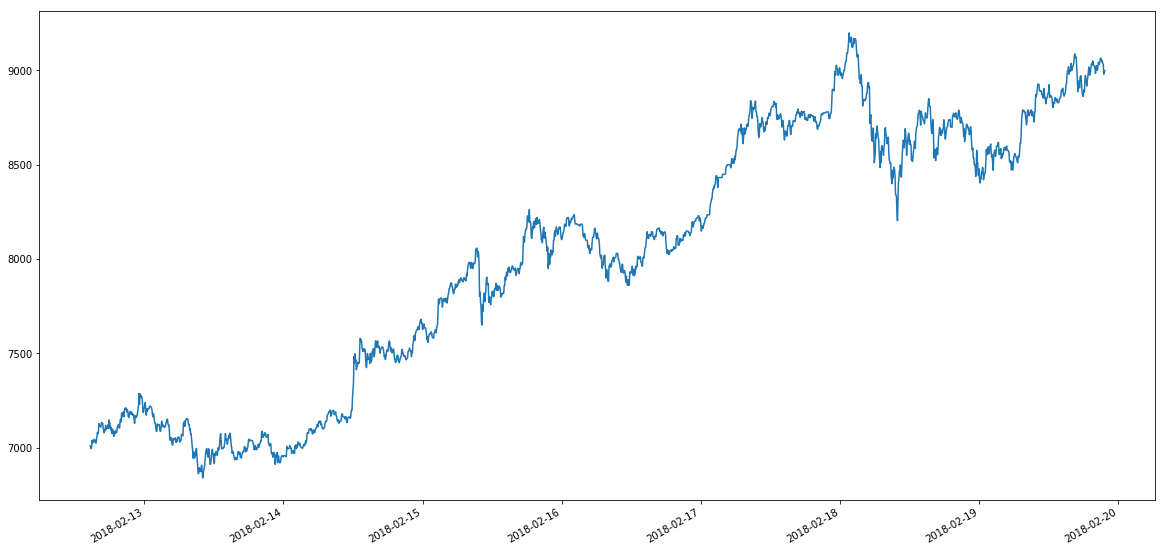

In [3]:
rates = historic_rates('BTC-EUR', 2000, granularity=300)
prices = [x[4] for x in rates]
while 'a' in prices: prices.remove('a')
times = [x[0] for x in rates]
while 'm' in times: times.remove('m')

prices.reverse()
times.reverse()

print(len(prices))

times_s = pd.Series(times).astype("datetime64[s]")
time_price = pd.Series(prices, times_s)

time_price.plot(figsize=(20,10))
print(prices[-1]/prices[0] * 100)
print(prices[:10])

In [4]:
class PriceWatchOscillator:
    def __init__(self, up_chg=0.0, down_chg=0.0, up_out_chg=0.0):
        self.last_max = 0.0
        self.last_min = sys.float_info.max
        self.out_mul = (1.0 - down_chg)
        self.in_mul = (1.0 + up_chg)
        self.up_out_mul = (1.0 + up_out_chg)
        self.stance = False
        self.in_price = 0
        self.out_price = 0
                
    def tick(self, price):
        if self.stance:
            if price > self.last_max:
                self.last_max = price
            if (price < self.last_max * self.out_mul) or (price > self.in_price * self.up_out_mul):
                self.stance = False
                self.out_price = price
                self.last_max = 0.0
        else:
            if price < self.last_min:
                self.last_min = price
            elif price > self.last_min * self.in_mul:
                self.stance = True
                self.in_price = price
                self.last_min = sys.float_info.max
        return self.stance

In [5]:
def backtest(up_chg, down_chg, up_out_chg, look_back, prices, warm_up=5):
    assert(len(prices) >= warm_up + look_back)

    algo = PriceWatchOscillator(up_chg=up_chg, down_chg=down_chg, up_out_chg=up_out_chg)
    
    for price in prices[-(warm_up + look_back):-look_back]:
        algo.tick(price)
    
    trader = Trader(algo, 
                    fee=0.0, 
                    trade_prob=1.0,
                    verbose=False)
    final = 0
    stance = False
    for price in prices[-look_back:]:
        final, stance = trader.tick(price)
    return final, stance, trader.num_trades

In [7]:
chart_back = 72
window = 1
potential = []

for up_chg in np.arange(0.0, 0.001, 0.0001):
    for down_chg in np.arange(0.0, 0.0001, 0.0001):
        for up_out_chg in np.arange(0.0, 0.03, 0.0001):
            value, _, _ = backtest(up_chg, down_chg, up_out_chg, chart_back, prices)
            potential.append((up_chg, down_chg, up_out_chg, value))
            
potential.sort(key=lambda tup: tup[3], reverse=True)
for sims in potential[:3]:
    print("{} {} {} {}".format(*sims))

print(prices[-1]/prices[-chart_back] * 100)


0.0006000000000000001 0.0 0.0061 100.5139152768027
0.0006000000000000001 0.0 0.006200000000000001 100.5139152768027
0.0006000000000000001 0.0 0.0063 100.5139152768027
100.04446919896519


In [ ]:
chart_back = 100
up_chg = 0.0
dwn_chg = 0.0
up_out_chg = 0.06

print(backtest(up_chg, dwn_chg, up_out_chg, chart_back, prices))

stances = []

pwo = PriceWatchOscillator(up_chg, dwn_chg)
for price in prices[-(chart_back):]:
    stances.append(pwo.tick(price))

    
fig, ax1 = plt.subplots(figsize=(20,10))
ax2 = ax1.twinx()
ax1.plot(prices[-chart_back:])
ax2.plot(stances[-chart_back:], "b")